# ODE for SEIR

# Setup

In [1]:
from pydantic import BaseModel, PositiveInt
from enum import Enum, Flag, auto
from pyvis.network import Network
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import networkx as nx
from typing import Any
from itertools import combinations, product

### Constants

In [2]:
DISPLAY_WIDTH = 800
DISPLAY_HEIGHT = 800

# Model

### Agent

In [3]:
class AgentState(Flag):
    S = auto()
    E = auto()
    I0 = auto()
    I1 = auto()
    I2 = auto()
    R = auto()
    H = auto()
    D = auto()

    INFECTIOUS = I0 | I1 | I2 | H
    IMMUNE = R | D | E

class AgentType(Enum):
    child = auto()
    adult = auto()
    retired = auto()


class Place(Enum):
    MISSING = auto()
    HOUSEHOLD = auto()
    HOSPITAL = auto()
    SCHOOL = auto()
    PRIMARY_CARE = auto()
    OTHER_WORKING_PLACE = auto()
    PUBLIC_PLACE = auto()




class Agent:
    agents: list["Agent"] = []

    @staticmethod
    def reset() -> None:
        Agent.agents = []

    def __init__(self, state: AgentState, type: AgentType) -> None:
        self._id = len(Agent.agents)
        self._state = state
        self.location_id: int | None = None
        self.house_id: int | None = None
        Agent.agents.append(self)
    
    @property
    def location(self) -> "Location":
        if self.location_id is None:
            msg = f"Location is missing for agent {self._id}"
            raise RuntimeError(msg)
        return Location.location[self.location_id]

    @property
    def house(self) -> "Location":
        if self.house_id is None:
            msg = f"House is missing for agent {self._id}"
            raise RuntimeError(msg)
        return Location.location[self.location_id]


### Location

In [18]:

class Location:
    locations: list["Location"] = []

    @staticmethod
    def reset() -> None:
        Location.locations = []

    @staticmethod
    def get_ids(type: Place) -> list[int]:
        return [i._id for i in Location.locations if i._type == type]

    def __init__(self, type: Place, size: int | None = None) -> None:
        self._id = len(Location.locations)
        self.max_size = size
        self.slots: list[Agent] = []
        self._type = type
        Location.locations.append(self)
    
    @property
    def id(self) -> int:
        return self._id
    
    @property
    def type(self) -> Place:
        return self._type
    
    def add_agent(self, agent: Agent):
        if len(self.slots) == self.max_size:
            msg = f"Reached slots limit in location {self._id}."
            raise RuntimeError(msg)
        self.slots.append(agent)
    
    def remove_agent(self, agent: Agent):
        try:
            self.slots.remove(agent)
        except:
            msg = f"Cannot remove non-existing agent from location {self._id}"
            raise RuntimeError(msg)


class Params(BaseModel):
    N: PositiveInt
    schools: PositiveInt



### Networks

In [73]:
class WorldParams(BaseModel):
    N: PositiveInt
    schools: PositiveInt
    primary_care: PositiveInt
    hospitals: PositiveInt
    other_working_places: PositiveInt
    public_places: PositiveInt

class NodesColors(Enum):
    HOUSEHOLD = "gray"
    SCHOOL = "brown"
    PRIMARY_CARE = "orange"
    HOSPITAL = "red"
    OTHER_WORKING_PLACE = "cyan"
    PUBLIC_PLACE = "green"

class World:
    def __init__(self, params: WorldParams, seed: int | None = None) -> None:
        self.params = params
        self.seed = seed
        self.households_capacities: NDArray[np.int64] | None = None
        self.reset()

        self.households_ids: list[int] = []
    
    def init(self) -> None:
        self.reset()
        self._add_places()
        network: dict[str, Any] = self._create_friendship_network()
        self._add_befriend_households_links(network)

    
    def reset(self) -> None:
        self.rng = np.random.default_rng(self.seed)
        self._g = nx.Graph()
        self._get_household_sizes()
        
    def _add_places(self) -> nx.Graph:
        households = [Location(Place.HOUSEHOLD) for _ in range(len(self.households_capacities))]
        public = []
        for (type_, N) in [
            (Place.HOSPITAL, self.params.hospitals),
            (Place.SCHOOL, self.params.schools),
            (Place.PRIMARY_CARE, self.params.primary_care),
            (Place.OTHER_WORKING_PLACE, self.params.other_working_places),
            (Place.PUBLIC_PLACE, self.params.public_places),
        ]:
            locations = [Location(type_) for _ in range(N)]
            public.extend(locations)
        self.households_ids = [h.id for h in households]
        public_ids = [p.id for p in public]
        self._g.add_nodes_from(self.households_ids + public_ids) #TODO: use objects instead integers
        self._g.add_edges_from(combinations(public_ids, 2))
        self._g.add_edges_from(product(public_ids, self.households_ids))
    
    def __call__(self) -> nx.Graph:
        return self._g
    
    def _create_friendship_network(self) -> None:
        p_rewire = 0.45
        G_people = nx.relaxed_caveman_graph(
            l=len(self.households_capacities),
            k=self.households_capacities.max(),
            p=p_rewire,
            seed=self.seed,
        )
        total_generated_nodes = len(G_people.nodes.keys())
        to_remove = np.max(total_generated_nodes - self.households_capacities.sum(), 0)
        nodes_to_remove = self.rng.choice(np.arange(total_generated_nodes), size=to_remove, replace=False)
        G_people.remove_nodes_from(nodes_to_remove)
        G_people = nx.relabel_nodes(G_people, mapping={prev: new for prev, new in zip(G_people.nodes.keys(), range(self.params.N))})
        
        person_to_household = {}
        current = 0
        for household_id, size in zip(self.households_ids, self.households_capacities):
            members = list(G_people.nodes)[current : current + size]
            for m in members:
                person_to_household[m] = household_id
            current += size
        return {"relations": G_people, "house_assign": person_to_household}

    def _get_household_sizes(self) -> None:
        p = [0.1, 0.3, 0.5, 0.05, 0.03, 0.02]
        size_range = np.arange(1, 6 + 1)
        sizes = []
        total = 0
        while total < self.params.N:
            s = self.rng.choice(size_range, p=p)
            sizes.append(s)
            total += s
        sizes = np.array(sizes)
        excess = total - self.params.N
        if excess > 0:
            sizes[-1] -= excess
            if sizes[-1] == 0:
                sizes = sizes[:-1]
        self.households_capacities = sizes
        
    def _add_befriend_households_links(self, network_details) -> None:
        G_people = network_details["relations"]
        p2h = network_details["house_assign"]
        household_edges = set()
        for u, v in G_people.edges:
            hu, hv = p2h[u], p2h[v]
            if hu == hv:
                continue
            key = tuple(sorted((hu, hv)))
            household_edges.add(key)
        for hu, hv in household_edges:
            self._g.add_edge(hu, hv)
    
    def draw(self) -> None:
        pos = nx.spring_layout(self._g, seed=self.seed)
        nx.draw_networkx_edges(self._g, pos)
        options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
        for place in Place:
            if place == Place.MISSING:
                continue
            nx.draw_networkx_nodes(self._g, pos, nodelist=Location.get_ids(place), node_color=f"tab:{NodesColors[place.name].value}", **options)


In [81]:
example_params = WorldParams(
    N=37,
    schools=1,
    primary_care=1,
    hospitals=1,
    other_working_places=1,
    public_places=1,
)

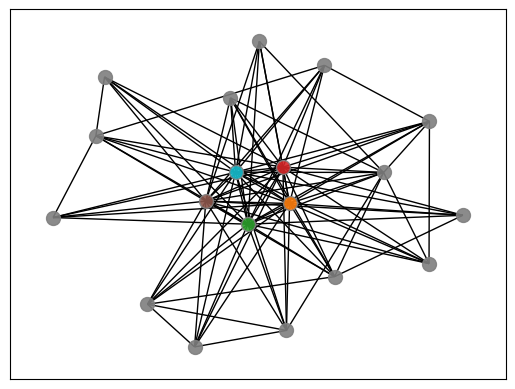

In [82]:
Location.reset()
Agent.reset()
w = World(example_params)
w.init()
np.array(w().degree())
w.draw()
# nx.draw(w())

In [8]:
class Params(BaseModel):
    T: PositiveInt
    N: PositiveInt
    schools: PositiveInt
    primary_care: PositiveInt
    hospitals: PositiveInt

class Simulation:
    def __init__(self, params: Params, seed: int | None = None) -> None:
        self.rng = np.random.default_rng(seed)
        self.params = params
        self.world = None
        self.world_params = None
        
    def init(self):
        self.
    
    

        
        

SyntaxError: invalid syntax (2975878357.py, line 16)

In [ ]:
def get_html_graph_viz(graph, filename: str) -> None:
    g = Network(height=DISPLAY_HEIGHT, width=DISPLAY_WIDTH)
    g.toggle_hide_edges_on_drag(True)
    g.barnes_hut()
    g.from_nx(graph, default_node_size=50)
    g.save_graph(filename)

# Data applied for params